### 데이터 불러오기

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)
test_label = [2,4,6] # Define actual test class that we use
actual_testdata = torch.isin(testset.targets, torch.tensor(test_label)) 
testset.data = testset.data[actual_testdata]
testset.targets = testset.targets[actual_testdata]

In [3]:
### 테스트 데이터셋 라벨링 2는 normal, 4,6은 anomaly로 라벨링
testset.targets = (testset.targets == 2).long() # 2 is normal, 4,6 is anomaly
test_loader = DataLoader(
    testset,
    batch_size = 1,
    shuffle = True,
    num_workers = 4
)

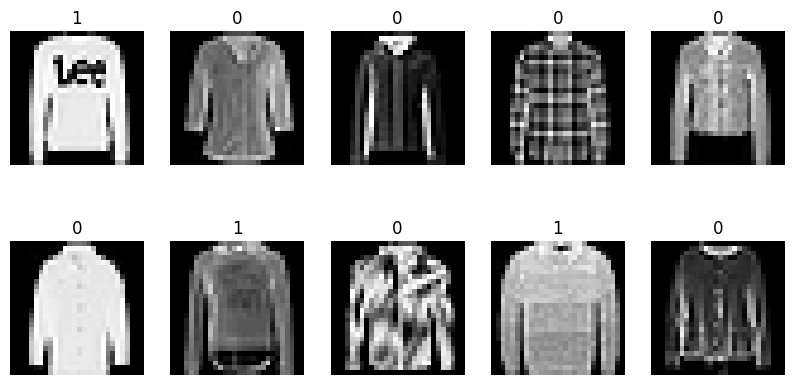

In [4]:
### data visualization
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title(str(testset.targets[i].item()))
    plt.imshow(testset.data[i], cmap='gray')
plt.show()

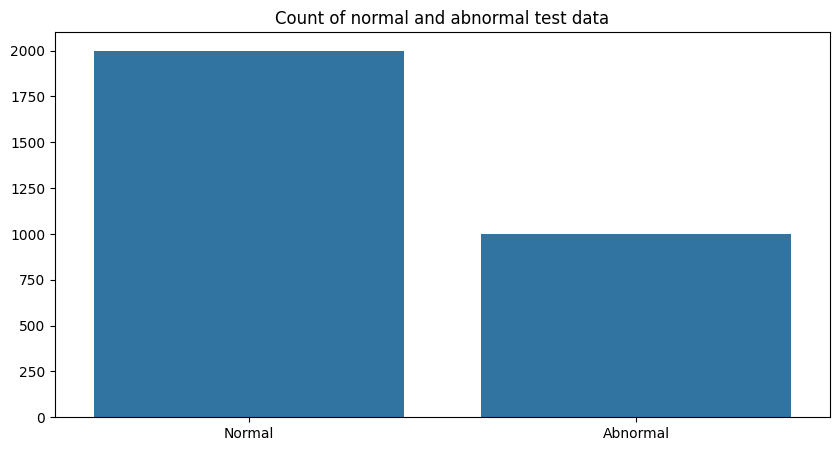

In [5]:
### 분포 보기 ab vs normal
import seaborn as sns
import pandas as pd

abnormal = (testset.targets == 1)
normal = (testset.targets == 0)

plt.figure(figsize=(10, 5))
plt.title('Count of normal and abnormal test data')

count_normal = normal.sum().item()
count_abnormal = abnormal.sum().item()

sns.barplot(x=['Normal', 'Abnormal'], y=[count_normal, count_abnormal])
plt.show()

### 테스트할 모델 불러오기 

In [6]:
from model.autoencoder import Autoencoder
model = Autoencoder() 
model.to(device)
model.load_state_dict(torch.load('./model_team8.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [7]:
from torchsummary import summary

# Assuming the model is already loaded and named 'model'
# Also assuming the input size is (1, 28, 28) for FashionMNIST
x = next(iter(test_loader))[0].to(device)
x = x.view(-1, 28*28).to(device)
summary(model, input_size=(x.size(1),))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                    [-1, 2]             258
            Linear-4                  [-1, 128]             384
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 784]         101,136
           Sigmoid-7                  [-1, 784]               0
Total params: 202,258
Trainable params: 202,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.77
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


### 성능 체크

In [14]:
# Test
THRESHOLDVAL=0.01 # threshold val
dic_loss = {'id':[], 'label':[], 'score':[],'normal':[]}

count=0
for step, (x, label) in enumerate(test_loader):
    # print(step,label)
    x = x.view(-1, 28*28).to(device)
    y = x.view(-1, 28*28).to(device)

    encoded, decoded = model(x)
    
    criterion = torch.nn.MSELoss(reduction='sum')
    loss = float(criterion(decoded, y).cpu().detach().numpy())
    dic_loss['id'].append(step)
    dic_loss['label'].append(int(label==1)) # actual label
    dic_loss['score'].append(loss) # abnormal score
    if loss>THRESHOLDVAL: dic_loss['normal'].append(0)
    else: dic_loss['normal'].append(1)

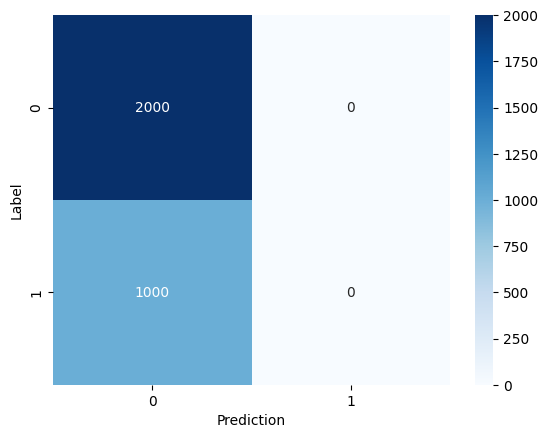

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
pred = dic_loss['normal'] # predicted label
label = dic_loss['label'] # actual label
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [ ]:
def plot(test_result, predict, true):